# 데이터 준비

In [1]:
import pandas as pd

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [1]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [2]:
train.drop(columns='Id', inplace=True)
test.drop(columns='Id', inplace=True)

In [3]:
y_train = train.loc[:, ['SalePrice']]
x_train = train.drop(columns='SalePrice')
x_test = test

In [4]:
x_train_int_col = x_train.select_dtypes(include='int64').columns
x_train_int = x_train[x_train_int_col]

# 데이터 탐색

## 상관계수 시각화

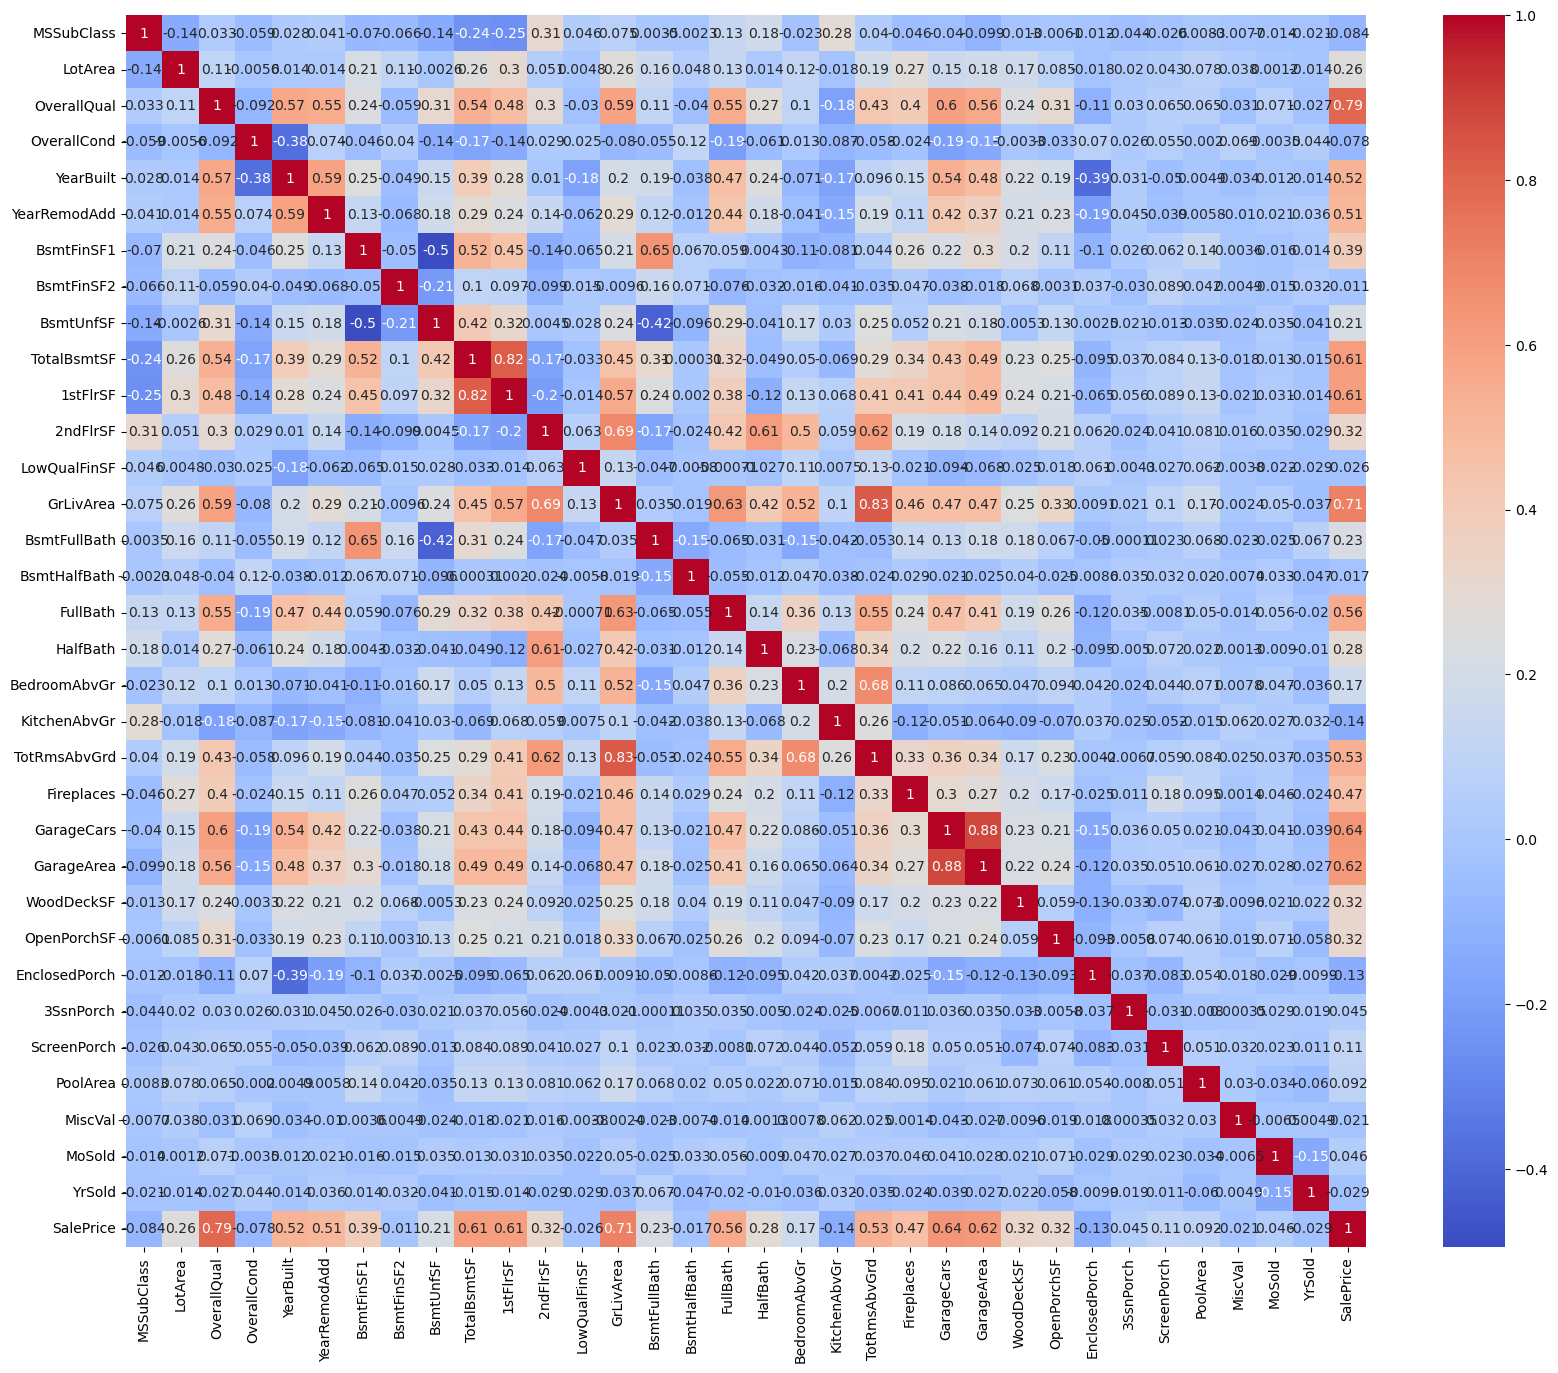

In [5]:
corr = pd.concat([train[x_train_int_col], train['SalePrice']], axis=1).corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [6]:
filterByCorr_col = corr[corr['SalePrice'].abs() >= 0.1].drop('SalePrice').index.tolist()

In [7]:
x_train = x_train[filterByCorr_col]

## VIF 확인 (다중공선성)

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif["features"] = x_train.columns
vif = vif.sort_values("VIF").reset_index(drop=True)
vif

,VIF,features
0,1.169271,ScreenPorch
1,1.328518,EnclosedPorch
2,1.801552,OpenPorchSF
3,1.851968,WoodDeckSF
4,2.530855,LotArea
5,2.920474,Fireplaces
6,3.177875,HalfBath
7,3.239129,BsmtFullBath
8,17.711051,BsmtFinSF1
9,21.492467,FullBath


In [33]:
vif_val_complete_col = vif.loc[:10, "features"]

In [34]:
# x_train 수정
vif_x_train = x_train[vif_val_complete_col].copy()

In [35]:
# x_test 수정
vif_x_test = x_test[vif_val_complete_col].copy()

In [55]:
# 범주형 2개 추가
vif_x_train['YrSold'] = train['YrSold'].copy()
vif_x_train['SaleType'] = train['SaleType'].copy()
vif_x_train['SaleCondition'] = train['SaleCondition'].copy()

vif_x_train[['SaleType', 'SaleCondition']] = \
vif_x_train[['SaleType', 'SaleCondition']].astype('category')

In [56]:
# 범주형 2개 추가
vif_x_test['YrSold'] = x_test['YrSold'].copy()
vif_x_test['SaleType'] = x_test['SaleType'].copy()
vif_x_test['SaleCondition'] = x_test['SaleCondition'].copy()

vif_x_test[['SaleType', 'SaleCondition']] = \
vif_x_test[['SaleType', 'SaleCondition']].astype('category')

In [57]:
vif_x_train = vif_x_train.dropna()
vif_x_test = vif_x_test.dropna()

## 카테고리형 범주 2개 사용하므로 원핫인코딩 진행

In [58]:
SaleType_onehot_train = pd.get_dummies(vif_x_train['SaleType'])
SaleCondition_onehot_train = pd.get_dummies(vif_x_train['SaleCondition'])

In [59]:
SaleType_onehot_test = pd.get_dummies(vif_x_test['SaleType'])
SaleCondition_onehot_test = pd.get_dummies(vif_x_test['SaleCondition'])

In [60]:
vif_x_train.drop(columns=['SaleType', 'SaleCondition'], inplace=True)
vif_x_test.drop(columns=['SaleType', 'SaleCondition'], inplace=True)

In [61]:
vif_x_train = pd.concat([vif_x_train, SaleType_onehot_train, SaleCondition_onehot_train], axis=1)
vif_x_test = pd.concat([vif_x_test, SaleType_onehot_test, SaleCondition_onehot_test], axis=1)

# 스케일링

## Min-Max 정규화

In [51]:
from sklearn.preprocessing import minmax_scale

scaled_x_train = minmax_scale(vif_x_train)
scaled_y_train = minmax_scale(y_train)

scaled_x_test = minmax_scale(vif_x_test)

## 최대절대값 정규화

In [47]:
from sklearn.preprocessing import maxabs_scale

scaled_x_train = maxabs_scale(vif_x_train)
scaled_y_train = maxabs_scale(y_train)

scaled_x_test = maxabs_scale(vif_x_test)

## 표준정규화

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(vif_x_train)
scaled_y_train = scaler.fit_transform(y_train)

scaled_x_test = scaler.fit_transform(vif_x_test)

## 스케일링 없음

In [66]:
scaled_x_train = vif_x_train
scaled_y_train = y_train
scaled_x_test = vif_x_test

---

# 모델링

In [62]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

## 선형회귀

In [93]:
model = LinearRegression()
model.fit(scaled_x_train, scaled_y_train)

LinearRegression()

In [94]:
y_pred = model.predict(scaled_x_test)

In [96]:
model.score(scaled_x_train, scaled_y_train)

0.6629230847406993

## 라쏘

In [79]:
model = Lasso(alpha=0.1)
model.fit(scaled_x_train, scaled_y_train)

C:\Users\hyesu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.458e+11, tolerance: 9.208e+08
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [80]:
y_pred = model.predict(scaled_x_test)

In [81]:
model.score(scaled_x_train, y_pred)

0.6629230804977733

## 릿지

In [73]:
model = Ridge(alpha=0.1)
model.fit(scaled_x_train, scaled_y_train)

Ridge(alpha=0.1)

In [74]:
y_pred = model.predict(scaled_x_test)

In [75]:
model.score(scaled_x_train, scaled_y_train)

0.6629216326971674

## 엘라스틱넷

In [82]:
model = ElasticNet(alpha=0.001)
model.fit(scaled_x_train, scaled_y_train)

ElasticNet(alpha=0.001)

In [83]:
y_pred = model.predict(scaled_x_test)

In [84]:
model.score(scaled_x_train, scaled_y_train)

0.6628718749900395

## 랜덤포레스트

In [85]:
from sklearn.ensemble import RandomForestRegressor

In [86]:
model = RandomForestRegressor(n_jobs=5, max_depth=8)
model.fit(scaled_x_train, scaled_y_train)

C:\Users\hyesu\AppData\Local\Temp\ipykernel_16268\2763320966.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(scaled_x_train, scaled_y_train)


RandomForestRegressor(max_depth=8, n_jobs=5)

In [87]:
model.predict(scaled_x_test)

array([129700.72112682, 147112.09138532, 223463.34667651, ...,
       202013.79340239, 121933.52024967, 221645.41616526])

In [88]:
model.score(scaled_x_train, scaled_y_train)

0.8879812131452208

In [89]:
feature_importance = pd.DataFrame(data = model.feature_importances_, index=vif_x_train.columns)
feature_importance.sort_values(by=0, ascending=False)

,0
FullBath,0.330818
BsmtFinSF1,0.256024
BsmtUnfSF,0.086133
LotArea,0.085060
OpenPorchSF,0.070737
Fireplaces,0.058856
HalfBath,0.030918
WoodDeckSF,0.022416
BsmtFullBath,0.010561
ScreenPorch,0.010353
